<a href="https://colab.research.google.com/github/dserenini/gerenciador-tarefas/blob/main/DIO_ML_1_Transfer_Learning_Cats_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning


In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/DIO/Transfer_Learning/kagglecatsanddogs_5340.zip -d /content/cats_and_dogs_dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Caminho para o dataset (substitua pelo caminho correto se necessário)
base_dir = '/content/cats_and_dogs_dataset/PetImages'

# Verificar subpastas
categories = os.listdir(base_dir)
print("Categorias encontradas:", categories)

# Verificar número de imagens em cada classe
for category in categories:
    category_dir = os.path.join(base_dir, category)
    print(f"Total de imagens em {category}: {len(os.listdir(category_dir))}")

Categorias encontradas: ['Cat', 'Dog']
Total de imagens em Cat: 12501
Total de imagens em Dog: 12501


In [5]:
# Criando os geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Divisão de 20% para validação
)

# Gerador para o conjunto de treinamento
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Redimensionamento das imagens
    batch_size=32,
    class_mode='binary',
    subset='training'  # Subconjunto de treinamento
)

# Gerador para o conjunto de validação
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subconjunto de validação
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Carregar o modelo base MobileNetV2 pré-treinado
base_model = MobileNetV2(input_shape=(224,224, 3), include_top=False, weights='imagenet')

# Congelar os pesos do modelo base para evitar treinar novamente suas camadas
base_model.trainable = False

# Construir a parte superior personalizada do modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Camada densa com 128 neurônios
    layers.Dropout(0.5),  # Dropout para evitar overfitting
    layers.Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

model.summary()  # Resumo da arquitetura do modelo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
import os
from PIL import Image, UnidentifiedImageError

# Caminho das subpastas
folders = ['Cat', 'Dog']

# Limpar arquivos não válidos
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:  # Abre a imagem no modo seguro
                img.verify()  # Verifica se é válida
        except (IOError, SyntaxError, UnidentifiedImageError):
            print(f"Removendo arquivo inválido: {file_path}")
            os.remove(file_path)  # Remove o arquivo se não for uma imagem

Removendo arquivo inválido: /content/cats_and_dogs_dataset/PetImages/Cat/666.jpg
Removendo arquivo inválido: /content/cats_and_dogs_dataset/PetImages/Cat/Thumbs.db
Removendo arquivo inválido: /content/cats_and_dogs_dataset/PetImages/Dog/11702.jpg
Removendo arquivo inválido: /content/cats_and_dogs_dataset/PetImages/Dog/Thumbs.db


In [18]:
import gc
import tensorflow.keras.backend as K

# Limpar memória e estado
K.clear_session()
gc.collect()

0

In [19]:
# Recriar o modelo base e a parte superior
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Recriar os geradores
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 521ms/step - accuracy: 0.9345 - loss: 0.1611 - val_accuracy: 0.9590 - val_loss: 0.0963
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 520ms/step - accuracy: 0.9583 - loss: 0.1028 - val_accuracy: 0.9656 - val_loss: 0.0814
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 523ms/step - accuracy: 0.9635 - loss: 0.0928 - val_accuracy: 0.9630 - val_loss: 0.0840
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 380s 520ms/step - accuracy: 0.9664 - loss: 0.0858 - val_accuracy: 0.9654 - val_loss: 0.0791
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 517ms/step - accuracy: 0.9632 - loss: 0.0890 - val_accuracy: 0.9716 - val_loss: 0.0739
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 380s 512ms/step - accuracy: 0.9667 - loss: 0.0808 - val_accuracy: 0.9700 - val_loss: 0.0793
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 320s 508ms/step - accuracy: 0.9677 - loss: 0.0796 - val_accuracy: 0.9640 - val_loss: 0.0821
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 318s 505ms/step - accuracy: 0.9695 -

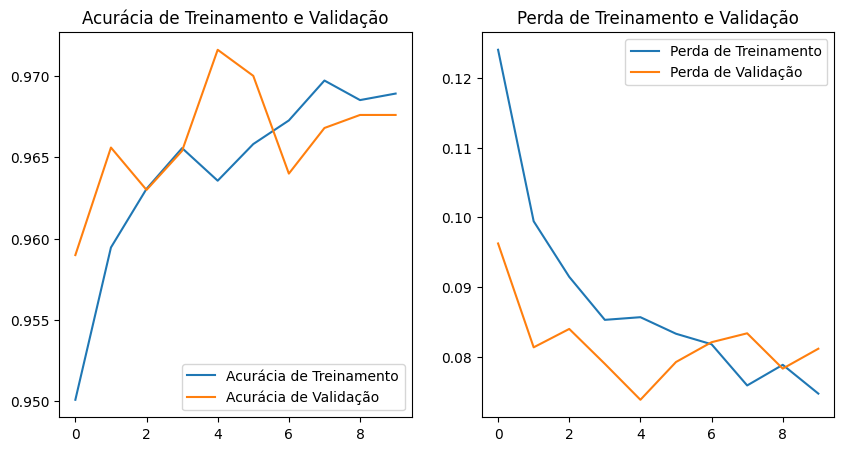

In [21]:
import matplotlib.pyplot as plt

# Função para plotar os gráficos de perda e acurácia
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Plotando a Acurácia
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treinamento e Validação')

    # Plotando a Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treinamento')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treinamento e Validação')

    plt.show()

# Chamando a função para plotar os gráficos
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


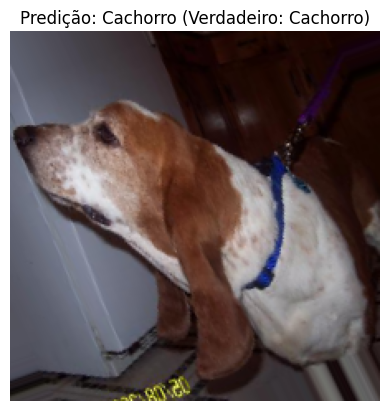

In [26]:
import random

# Obter um batch aleatório do gerador de validação
images, labels = next(validation_generator)
index = random.randint(0, len(images) - 1)

# Fazer a predição
predicted_label = model.predict(np.expand_dims(images[index], axis=0))[0][0]
true_label = labels[index]

# Exibir a imagem com a predição
plt.imshow(images[index])
plt.axis('off')
plt.title(f'Predição: {"Cachorro" if predicted_label > 0.5 else "Gato"} (Verdadeiro: {"Cachorro" if true_label else "Gato"})')
plt.show()